# Week 13 (Monday), AST 8581 / PHYS 8581 / CSCI 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>

# Where do we stand?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction -> Principle Component Analysis -> Clustering -> Density Estimation / Anomaly Detection -> Supervised Learning -> Deep Learning -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL -> Introduction to Multiprocessing

# Introduction
With data increasing exponentially with time and growth in processor’s computing power coming to a hold, we need to find ways to process data efficiently and effectively. What should we do?
GPUs are one solution, and they are very effective. But, GPUs were not made for Machine Learning purposes, they were specifically made for complex image processing and gaming. We made our algorithms to work on existing GPUs and it actually paid off. Now, Google has introduced a new device, called TPU (Tensor Processing Unit), which is tailored for machine learning workloads on TensorFlow and the results do look promising. And Nvidia is also not backing off.

But we will hit the ceiling at some point in the future. Even if we take any of the enormous datasets available today, a single machine or computing unit will not be sufficient to handle such load. We will have to use multiple machines to do our task(s). We will have to Parallelize our task(s).
In this lecture, we will look into some of the methods which you will work with most of the time in Python. And then a little introduction to Dask and torch.multiprocessing.

# Pool and Process 

Both Pool and Process methods of multiprocessing library of Python initiates a new process for our task, but in a different way. 

Process makes only one process per call:

```
import multiprocessing as mp
p = mp.Process(target= ##target-function,
               args=   ##args-to-func)
```               
               
This call will make only one process, which will process target-function with given arguments in background.
But the process still hasn’t started. To start it you have to do:
```
p.start()
```
Now you can either leave it here, or check if the process is complete or not by:

```
p.join()
```

Now it will wait for process to complete. There can be many uses of not checking if the process has completed or not. For example, in a Client-Server Application where the probability of packet being lost, or a non-responding process is really low, we can neglect it which can give us considerable speedup. 

For multiple processes, you will have to make multiple Process'. You can make as many you like. All of them will start when you invoke .start() on them.
```
processes =[mp.Process(target=func, args=(a, b)) for (a, b) in list]
for p in processes: p.start()
for p in processes: p.join()
```

On the other hand a Pool initiates a fixed number of processes and then we can assign some tasks to those processes. So, at a particular instance of time only a fixed amount of processes will be running and the rest will be waiting. The number of processes are mostly chosen as number of cores of your device, which is also the default behavior if you leave the argument empty.

```
pool = mp.Pool(processes=2)
```

Now there are many methods which you can apply to use this Pool. Ones we can get away with, in Data Science, are Pool.apply and Pool.map, because they return the result as soon as task(s) are complete. Pool.apply takes only one argument and uses only one process, whereas Pool.map takes many arguments and puts them onto our Pool of processes.
```
results = [pool.apply(func, (x)) for x in X]
```
or 
```
results = pool.map(func, (arg)) # Takes only one argument
```
But Pool.map takes only one argument (iterable) which it divides into number of chunks. To send in many arguments you can do something like this.

Considering our previous example of Client-Server Application, here max number of processes to be running are predefined, so if we have a lot of requests/packets, only n (max processes in Pool) of them will be running at a time, and others will be in queue for one of the processes slot waiting for its turn.

## Example: Squaring of all elements of a vector
How can we use it with Data Frame?

You can use some parallelizable function
It can come in handy for preprocessing of data.

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool

df = pd.DataFrame(np.random.randint(0,100,size=(100, 100)))
df.shape
# (100, 100)
dfs = [df.iloc[i*25:i*25+25, 0] for i in range(4)]
with Pool(4) as p:
    res = p.map(np.exp, dfs)
for i in range(4): df.iloc[i*25:i*25+25, 0] = res[i]

print(res)

[0     5.540622e+34
1     1.338335e+42
2     1.014800e+33
3     3.404276e+29
4     2.293783e+27
5     6.235149e+27
6     8.223013e+36
7     8.659340e+16
8     5.685720e+24
9     6.235149e+27
10    5.459815e+01
11    3.637971e+42
12    5.685720e+24
13    2.038281e+34
14    6.565997e+07
15    5.320482e+11
16    2.038281e+34
17    1.545539e+25
18    6.663176e+40
19    6.663176e+40
20    1.252363e+29
21    1.318816e+09
22    4.034288e+02
23    1.784823e+08
24    5.987414e+04
Name: 0, dtype: float64, 25    1.142007e+26
26    2.904885e+13
27    1.694889e+28
28    1.373383e+32
29    1.112864e+36
30    4.424134e+05
31    2.202647e+04
32    9.253782e+29
33    2.718282e+00
34    4.607187e+28
35    4.311232e+15
36    9.253782e+29
37    3.404276e+29
38    4.851652e+08
39    3.931334e+12
40    6.663176e+40
41    1.545539e+25
42    4.923458e+41
43    1.957296e+11
44    3.104298e+26
45    5.685720e+24
46    6.398435e+17
47    1.000000e+00
48    2.758513e+33
49    1.318816e+09
Name: 0, dtype: float64,

## What to use and when?
If you have a lot of tasks and not many of them are compute intensive, you should use a Process. Because if they are compute intensive, they might clog your CPU and your system might crash. And they won’t have to wait in queue for their chance if your system can handle them all at once. And when you have fixed amount of tasks and they are very compute intensive, you should use a Pool. Because if you set them loose all at once, your system might crash.

# Threading

Threading in python has a bad reputation. And people are correct. Threading actually doesn’t work as it should most of the time. So what is the problem? The problem is GIL (Global Interpreter Lock). GIL was introduced early on Python’s development when there wasn’t even concept of Threads in Operating Systems. It was chosen for its simplicity. GIL allows only one CPU bound process at a time. That is, it gives access of python interpreter to only one thread at a time. So, a threadLocks the whole interpreter until it completes.

For single-threaded programs it was fast as there was only one Lock to maintain. And as python became popular it became hard to effectively put out GIL and not harm all the dependent applications. And that’s why its still there. But, you can still use multi-threading parallel(y) if your task is not CPU bound. That is you can use multiple threads and get speedup if your task is I/O bound. Because most of the time these tasks are waiting for response from other agent (like disk etc.) and in that time they can release the lock, leaving it for other tasks to acquire it in meantime.

NOTE: (From official page here)
The GIL is controversial because it prevents multithreaded CPython programs from taking full advantage of multiprocessor systems in certain situations. Note that potentially blocking or long-running operations, such as I/O, image processing, and NumPy number crunching, happen outside the GIL. Therefore it is only in multithreaded programs that spend a lot of time inside the GIL, interpreting CPython bytecode, that the GIL becomes a bottleneck.
So, if your task is IO bound, something like downloading some data from server, read/write to disk etc., you can use multiple threads and get speedups.

```
from threading import Thread as t
import queue
q = queue.Queue()  # For putting and getting results of thread
func_ = lambda q, args: q.put(func(args))
threads = [t(target=func_, args=(q, args)) for args in args_array]
for t in threads: t.start()
for t in threads: t.join()
res = []
for t in threads: res.append(q.get()) 
# These results won't necessarily be in order
```

To save results from Threads, you can use something like Queue. And for that you will have to define your function as shown above or you can use Queue.put() inside your function, but for that you will have to change your function definition to include Queue as argument.
Now, your results in queue won’t necessarily be in order. If you want your results to be in order you can pass in some counter as arguments, as ids, and then use those ids to identify where the result came from.

```
threads = [t(func_, args = (i, q, args)) for i, args in 
                                         enumerate(args_array)]
```
                                         
And update the function accordingly

# Threads vs Processes?

A process is heavy-weight as it may contain many threads of its own (contains at least one) and it has its own memory space allocated, whereas threads are light-weight as it works on memory area of parent process and thus faster to make. Communication between threads inside a process is easier because they share same memory space., whereas communication between processes (IPC-Inter Process Communication) is slower. But then again, threads sharing same data can get into race condition, and should be taken care of using Locks or similar solutions.

# Dask

Dask is a parallel computing library which doesn’t just help parallelize existing Machine Learning tools (Pandas andNumpy)[i.e. using High Level Collection], but also helps parallelize low level tasks/functions and can handle complex interactions between these functions by making a tasks’ graph.[i.e. using Low Level Schedulers] This is similar to Threading or multiprocessing modules of Python.

They also have a separate Machine Learning library, dask-ml, which has integration with existing libraries such as sklearn, xgboost and tensorflow.

```
from dask import delayed as delay
@delay
def add(x, y):
    return x+y
@delay
def sq(x):
    return x**2    
 
# Now you can use these functions any way you want, Dask will 
# parallelize your execution. And as the name suggest Dask 
# will not execute your function callings right away, rather
# it will make a computational graph depending on the way you are
# calling functions on inputs and intermediate results. To compute
# final result:
result.compute()
```

Dask has a inherently parallel nature of doing everything. For how it handles DataFrames, you can think of it as a Divide and Conquer approach, where it divides your DataFrame into chunks and then apply your given function in parallel.

They also have interface for running them on cluster of machines.

In [2]:
%pip install -U tornado
%pip install dask --upgrade

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00a 0:00:01
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 13.1 MB/s eta 0:00:00
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
  Using cached locket-1.0.0-py2.py3-none-any.whl (4.4 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import dask.dataframe as dd

# subset of file here: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/files/vault/cirada/continuum/VLASS_QL_comp_catalogues_yg/VLASS1QLCIR_v1/CIRADA_VLASS1QL_table1_components_v1.csv.gz

df = dd.read_csv("data/CIRADA_VLASS1QL_table1_components_v1_head_10000.csv", blocksize=2*1e6) # 2 MB
print(df)
# Your DataFrame has been divided into chunks and every function
# you apply will be applied to all chunks separately and in 
# parallel.
# It has most of Pandas functions which you can use:
agg = df.groupby("Total_flux").Total_flux.aggregate(["sum", "mean"])
agg.columns = ["Total_flux_sum", "Total_flux_mean"]
df_new = df.merge(agg.reset_index(), on="Total_flux", how="left")
agg.head()
# It have not compute result up until now,
# but with .compute() it will compute now in parallel.
df_new.compute().head()

Dask DataFrame Structure:
              Component_name Component_id Isl_id       RA      DEC     E_RA    E_DEC Total_flux E_Total_flux Peak_flux E_Peak_flux      Maj    E_Maj      Min    E_Min       PA     E_PA Isl_Total_flux E_Isl_Total_flux  Isl_rms Isl_mean Resid_Isl_rms Resid_Isl_mean   RA_max  DEC_max E_RA_max E_DEC_max  S_Code    Xposn  E_Xposn    Yposn  E_Yposn Xposn_max E_Xposn_max Yposn_max E_Yposn_max Maj_img_plane E_Maj_img_plane Min_img_plane E_Min_img_plane PA_img_plane E_PA_img_plane   DC_Maj E_DC_Maj   DC_Min E_DC_Min    DC_PA  E_DC_PA DC_Maj_img_plane E_DC_Maj_img_plane DC_Min_img_plane E_DC_Min_img_plane DC_PA_img_plane E_DC_PA_img_plane    Tile Subtile QL_image_RA QL_image_DEC NVSS_distance FIRST_distance Peak_to_ring Duplicate_flag Quality_flag Source_name Source_type QL_cutout  NN_dist     BMAJ     BMIN      BPA
npartitions=5                                                                                                                                               

,Component_name,Component_id,Isl_id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,...,Quality_flag,Source_name,Source_type,QL_cutout,NN_dist,BMAJ,BMIN,BPA,Total_flux_sum,Total_flux_mean
0,VLASS1QLCIR J000000.04+800045.6,90,125,0.000177,80.012667,0.000075,0.000112,0.818652,0.318866,0.752668,...,2,NaN,N/,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/ca...,4.090731,3.292111,2.205925,10.809265,0.818652,0.818652
1,VLASS1QLCIR J000000.05+441010.5,4,8,0.000222,44.169596,0.000184,0.000107,5.166948,1.273459,1.068693,...,3,NaN,N/,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/ca...,23.102499,2.838859,2.162387,41.666328,5.166948,5.166948
2,VLASS1QLCIR J000000.07-062930.6,63,94,0.000296,-6.491848,0.000085,0.000076,1.905655,0.443845,1.204416,...,0,J000000.07-062930.6,SC,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/ca...,104.898297,3.594396,2.223308,31.344944,1.905655,1.905655
3,VLASS1QLCIR J000000.08+275057.9,-6,55,0.000369,27.849437,0.000000,0.000000,0.000000,0.000000,1.149879,...,4,NaN,N/,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/ca...,-99.000000,2.957121,2.348967,80.226173,0.000000,0.000000
4,VLASS1QLCIR J000000.08+190239.5,36,34,0.000373,19.044331,0.000042,0.000050,4.456763,0.930580,2.734357,...,0,NaN,N/,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/ca...,-99.000000,2.345142,1.928372,35.547150,4.456763,4.456763


# torch.multiprocessing

torch.multiprocessing is a wrapper around Python multiprocessing module and its API is 100% compatible with original module. So you can use Queue's, Pipe's, Array's etc. which are in Python’s multiprocessing module here. To add to that, to make it faster they have added a method, share_memory_(), which allows data to go into a state where any process can use it directly and so passing that data to as argument to different processes won’t make copy of that data.

You can share Tensors, model’s parameters, and you can share them on CPU or GPU as you like.
Warning from Pytorch: (Regarding sharing on GPU)
  CUDA API requires that the allocation exported to other processes remains valid as long as it’s used by them. You should be careful and ensure that CUDA tensors you shared don’t go out of scope as long as it’s necessary. This shouldn’t be a problem for sharing model parameters, but passing other kinds of data should be done with care. Note that this restriction doesn’t apply to shared CPU memory.
  
You can use methods above in "Pool and Process" section here, and to get more speedup you can use share_memory_() method to share a Tensor(say) among all processes without being copied.

```
# Training a model using multiple processes:
import torch.multiprocessing as mp
def train(model):
    for data, labels in data_loader:
        optimizer.zero_grad()
        loss_fn(model(data), labels).backward()
        optimizer.step()  # This will update the shared parameters
model = nn.Sequential(nn.Linear(n_in, n_h1),
                      nn.ReLU(),
                      nn.Linear(n_h1, n_out))
model.share_memory() # Required for 'fork' method to work
processes = []
for i in range(4): # No. of processes
    p = mp.Process(target=train, args=(model,))
    p.start()
    processes.append(p)
for p in processes: p.join()
```

You can also work with a cluster of machines.

# Using basic numba functionalities (Just @jit it!)

In [5]:
import os
import numpy as np # Numba supports many functions from numpy (https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html)
from numba import jit, njit, vectorize, cuda
import math # Numba supports many functions from math (http://numba.pydata.org/numba-doc/0.17.0/reference/pysupported.html)

import matplotlib.pyplot as plt

**Numba** (http://numba.pydata.org) is a package created by Anaconda, Inc (http://www.anaconda.com). Numba takes pure Python code and translates it automatically (just-in-time) into optimized machine code. In practice, this means that we can write a non-vectorized function in pure Python, using `for` loops, and have this function vectorized automatically by using a single decorator. Performance speedups when compared to pure Python code can reach several orders of magnitude and may even outmatch manually-vectorized NumPy code.

In this section, we will show how to accelerate pure Python code generating the Mandelbrot fractal.

Python bytecode is normally interpreted at runtime by the Python interpreter (most often, CPython). By contrast, a Numba function is parsed and translated directly to machine code ahead of execution, using a powerful compiler architecture named **LLVM (Low Level Virtual Machine)**.

Numba supports a significant but not exhaustive subset of Python semantics. You can find the list of supported Python features at http://numba.pydata.org/numba-doc/latest/reference/pysupported.html. When Numba cannot compile Python code to assembly, it will automatically fallback to a much slower mode. You can prevent this behavior with `@jit(nopython=True)`.

Numba generally gives the most impressive speedups on functions that involve tight loops on NumPy arrays (such as in this recipe). This is because there is an overhead running loops in Python, and this overhead becomes non-negligible when there are many iterations of few cheap operations. In this example, the number of iterations is `size * size * iterations = 16,000,000`.

Let's compare the performance of Numba with manually-vectorized code using NumPy, which is the standard way of accelerating pure Python code such as the code given in this recipe. In practice, it means replacing the code inside the two loops over `i` and `j` with array computations. This is relatively easy here as the operations closely follow the **Single Instruction, Multiple Data (SIMD)** paradigm:

Numba supports many other features, like multiprocessing and GPU computing.


Here are a few references:

* Documentation of Numba available at http://numba.pydata.org
* Supported Python features in Numba, available at http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
* Supported NumPy features in Numba, available at http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html

In [6]:
a = np.ones((1, 100), dtype=np.float64)
b = np.ones((100, 1), dtype=np.float64)

In [7]:
#
# Simple Python function
#

def func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [9]:
%timeit res = func(a, b)

791 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
#
# Numba with nopython = True
#

@njit      # or @jit(nopython=True)
def njit_func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

In [11]:
%timeit res = njit_func(a, b)

122 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
#
# Basic Numba compiler with type information provided
#

@jit('float64(float64, float64)')
def jit_func(a, b):
  for i in range(100000):
    constant = math.pow((a@b)[0][0], 1./2)/math.exp((a@b)[0][0]/1000)
    a = np.array([[constant]*100], dtype=np.float64)
  return a

/var/folders/fn/00zl2mgj5w1_bhvyzl0w1tp00000gn/T/ipykernel_63740/3803508498.py:5: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "jit_func" failed type inference due to: No implementation of function Function(<built-in function matmul>) found for signature:
 
 >>> matmul(float64, float64)
 
There are 2 candidate implementations:
   - Of which 2 did not match due to:
   Overload of function 'matmul': File: numba/core/typing/npydecl.py: Line 970.
     With argument(s): '(float64, float64)':
    No match.

During: typing of intrinsic-call at /var/folders/fn/00zl2mgj5w1_bhvyzl0w1tp00000gn/T/ipykernel_63740/3803508498.py (8)

File "../../../../../../../../var/folders/fn/00zl2mgj5w1_bhvyzl0w1tp00000gn/T/ipykernel_63740/3803508498.py", line 8:
<source missing, REPL/exec in use?>

  @jit('float64(float64, float64)')
/var/folders/fn/00zl2mgj5w1_bhvyzl0w1tp00000gn/T/ipykernel_63740/3803508498.py:5: NumbaWarning: 
Compilation is falling back to

In [13]:
%timeit res = jit_func(a, b)

119 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/var/folders/fn/00zl2mgj5w1_bhvyzl0w1tp00000gn/T/ipykernel_63740/2198876747.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["pyFunc", "Jit", "Njit"])


Text(0.5, 0, 'Method')

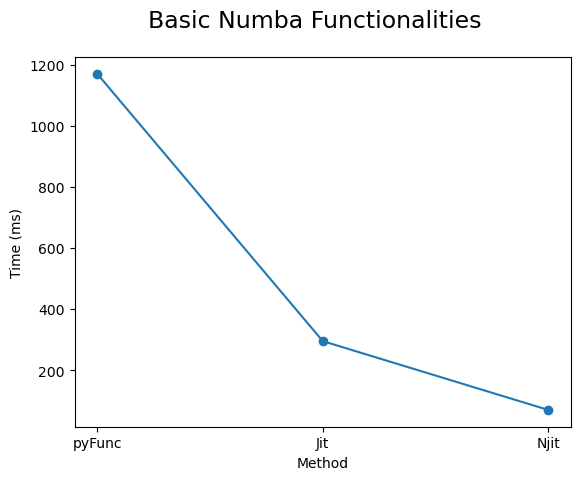

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(["a", "b", "c"], [1170, 295, 69.8], "-o") # Results without caching
ax.set_xticklabels(["pyFunc", "Jit", "Njit"])
fig.suptitle("Basic Numba Functionalities", fontsize=17)
ax.set_ylabel("Time (ms)")
ax.set_xlabel("Method")

## Numba also provies a @vectorize wrapper

In [19]:
#
# Making Ufuncs with Numba.
#

@vectorize
def vec_func(a, b):
  # Now we can pass arrays too, and operate
  # inside like they are scalars:
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a
# This is similar to functions before, for comparison. But...

In [20]:
%timeit res = vec_func(a, b)

29.6 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#
# This is slow because previously we were doing some
# operations on 1,00,000 scalars obtained by multiplying
# (a@b), but now we are multiplying individual elements 
# of a and b for 1,00,000 times. Also numba is taking care
# of broadcasting too. So, in this case we are applying this
# loop for 100 times.
#

In [21]:
@vectorize(['float64(float64, float64)'], target='parallel')
def vecParallel_func(a, b):
  for i in range(100000):
    a = math.pow(a*b, 1./2)/math.exp(a*b/1000)
  return a

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [25]:
%timeit res = vecParallel_func(a, b)

1 loop, best of 5: 16.8 s per loop


# Initial

### Torch:

In [15]:
!pip -q install torchvision

### Dask:

In [ ]:
# https://stackoverflow.com/questions/49853303/how-to-install-pydot-graphviz-on-google-colab?rq=1
!pip -q install graphviz 
!apt-get install graphviz -qq
!pip -q install pydot

# Import

In [ ]:
import numpy as np
import pandas as pd
from multiprocessing import Pool, Process
import torch

In [ ]:
import matplotlib.pyplot as plt

# 1. Pool and Process

In [ ]:
import multiprocessing as mp
mp.cpu_count()

2

### Pool:

In [ ]:
def function(lst):
  arr = np.zeros_like(lst)
  for i in range(lst.shape[0]):
    for j in range(lst.shape[1]):
      arr[i][j] = lst[i][j] ** 2
  return arr

array = np.random.randint(1, 9, (2**10, 10000))
data = np.array_split(array, 2)

In [ ]:
data[0].shape

(512, 10000)

In [ ]:
%%time
with Pool(2) as p:
  res = p.map(function, data)
  p.close()
  p.join()

CPU times: user 115 ms, sys: 280 ms, total: 396 ms
Wall time: 6.78 s


### Process:

In [ ]:
%%time
processes = []
for i in range(2):
  p = Process(target=function, args=(data[i],))
  processes.append(p)
  p.start()
  
for p in processes: p.join()

CPU times: user 3.94 ms, sys: 74.6 ms, total: 78.5 ms
Wall time: 8.02 s


### Graphing:

In [ ]:
def function(lst):
  arr = np.zeros_like(lst)
  for i in range(lst.shape[0]):
      arr[i] = lst[i] ** 2
  return arr

In [ ]:
import time

def serial(n, start=0):
  times = []
  size = []
  for i in range(start, n):
    s = 10**(i+1)
    size.append(s)
    lst = np.random.randint(1, 7, (s,))
    st = time.time()
    res = function(lst)
    en = time.time()
    times.append(en-st)
  return times, size

def parallel(n, sp, start=0):
  times = []
  size = []
  for i in range(start, n):
    s = 10**(i+1)
    size.append(s)
    lst = np.random.randint(1, 7, (s,))
    splitted = np.split(lst, sp)
    with Pool(sp) as p:
      st = time.time()
      res = p.map(function, splitted)
      en = time.time()
    times.append(en-st)
  return times, size

def parallel2(n, sp, start=0):
  """ 
    sp: Number of splits of array and number of processes
    start: Change it so that split function is able to split
  """
  times = []
  size = []
  for i in range(start, n):
    s = 10**(i+1)
    size.append(s)
    lst = np.random.randint(1, 7, (s,))
    splitted = np.split(lst, sp)
    processes = []
    st = time.time()
    for j in range(sp):
      p = Process(target=function, args=(splitted[j],))
      processes.append(p)
    for p in processes: p.start()
    for p in processes: p.join()
    en = time.time()
    times.append(en-st)
  return times, size

In [ ]:
%%time
t1, s1 = serial(6)

CPU times: user 409 ms, sys: 17.5 ms, total: 427 ms
Wall time: 431 ms


In [ ]:
%%time
t2, s2 = parallel(6, 2)

CPU times: user 60 ms, sys: 618 ms, total: 678 ms
Wall time: 1.91 s


In [ ]:
%%time
t3, s3 = parallel2(6, 2)

CPU times: user 32.7 ms, sys: 492 ms, total: 524 ms
Wall time: 1.01 s


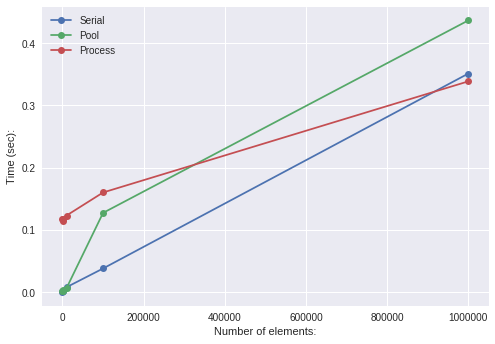

In [ ]:
plt.plot(s1, t1, "o-", label="Serial")
plt.plot(s2, t2, "o-", label="Pool")
plt.plot(s3, t3, "o-", label="Process")
plt.legend()
plt.xlabel("Number of elements:")
plt.ylabel("Time (sec):")
plt.show()
# Our task is not that heavy, results here may vary unexpectedly.

# 2. Threading

In [ ]:
from threading import Thread as trd
import queue
q = queue.Queue()

In [ ]:
def function(lst):
  arr = np.zeros_like(lst)
  for i in range(lst.shape[0]):
    for j in range(lst.shape[0]):
      arr[i][j] = lst[i][j] * lst[i][j]
  return arr

array = np.random.randint(1, 10, (1000, 10000))
data = np.array_split(array, 2)

In [ ]:
%%time
res = function(array)

CPU times: user 934 ms, sys: 16.4 ms, total: 950 ms
Wall time: 954 ms


In [ ]:
%%time
# By using Queue this way you can get result of function without
# modifying your function.
t1 = trd(target=lambda q, args1: q.put(function(args1)), args=(q, data[0]))
t2 = trd(target=lambda q, args1: q.put(function(args1)), args=(q, data[1]))

t1.start()
t2.start()

t1.join()
t2.join()

res1 = q.get()
res2 = q.get()

CPU times: user 489 ms, sys: 22.4 ms, total: 511 ms
Wall time: 496 ms


In [ ]:
q.empty()

True

# 3. Dask

In [ ]:
from dask import delayed as delay

@delay
def add(x, y): return x+y
@delay
def sq(x): return x**2
@delay
def sum(x): 
  sum=0
  for i in range(len(x)): sum+=x[i]
  return sum

In [ ]:
inputs = list(np.arange(1, 11))

res = [sq(n) for n in inputs]
res = [add(n, m) for n, m in zip(res[::2], res[1::2])]
res = sum(res)

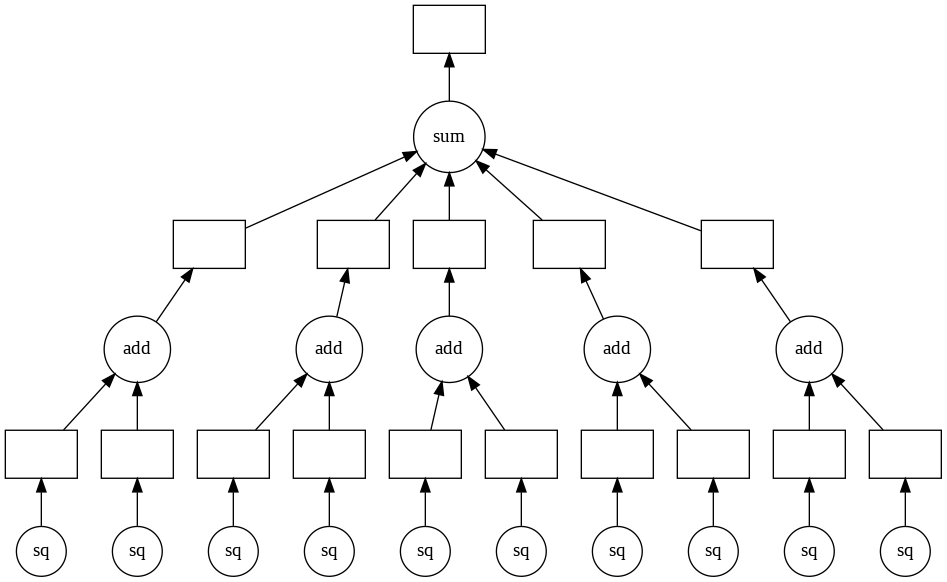

In [ ]:
res.visualize()

In [ ]:
res.compute()

385

# 4. torch.multiprocessing

In [ ]:
import torch.multiprocessing as mp_
mp = mp_.get_context('spawn')

In [ ]:
a = torch.zeros((1000, 1000))
b = torch.zeros_like(a).cuda()

In [ ]:
def func(arr):
  for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
      arr[i][j] += (i+j)
      arr[i][j] *= arr[i][j]
  return arr

In [ ]:
%%time
res = func(a)

CPU times: user 22 s, sys: 1.79 s, total: 23.8 s
Wall time: 23.8 s


In [ ]:
%%time
res = func(b)

CPU times: user 2min 56s, sys: 54.9 s, total: 3min 51s
Wall time: 3min 51s


### Training Model using multiple processes:

In [ ]:
import torch.multiprocessing as mp_
mp = mp_.get_context('spawn')
import torch.nn as nn

In [ ]:
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset
X, y = make_classification(n_samples=10000, )

dataset = TensorDataset(torch.FloatTensor(X), torch.DoubleTensor(y))
data_loader = DataLoader(dataset, batch_size=8)

In [ ]:
n_in = 20; n_out = 1        
        
model = nn.Sequential(nn.Linear(n_in, 15),
                      nn.ReLU(),
                      nn.Linear(15, 10),
                      nn.ReLU(),
                      nn.Linear(10, 5),
                      nn.ReLU(),
                      nn.Linear(5, n_out),
                      nn.Sigmoid())

model.share_memory() # Required for 'fork' method to work

Sequential(
  (0): Linear(in_features=20, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=1, bias=True)
  (7): Sigmoid()
)

In [ ]:
def train(model):
    for data, labels in data_loader:
        optimizer.zero_grad()
        loss_fn(model(data), labels).backward()
        optimizer.step()  # This will update the shared parameters

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True)
loss_fun = torch.nn.BCELoss()

In [ ]:
processes = []
for i in range(4): # No. of processes
    p = mp.Process(target=train, args=(model,))
    p.start()
    processes.append(p)
for p in processes: p.join()

In [ ]:
sum=0
for data, labels in data_loader:
  with torch.no_grad():
    res = model(data)
    res[res>=0.7] = 1
    res[res<0.7] = 0
    sum += (res.numpy()!=labels.float().numpy()).diagonal().sum()

    
sum/10000

0.4994

# Import

In [30]:
!pip install fsspec

     |████████████████████████████████| 112kB 8.6MB/s 


In [20]:
import numpy as np
import pandas as pd
import dask.array as da
import graphviz

In [ ]:
import matplotlib.pyplot as plt

# 2. Data Types

**Dask** is a parallel computing library that offers not only a general framework for distributing complex computations on many nodes, but also a set of convenient high-level APIs to deal with out-of-core computations on large arrays. Dask provides data structures resembling NumPy arrays (*dask.array*) and pandas DataFrames (*dask.dataframe*) that efficiently scale to huge datasets. The core idea of Dask is to split a large array into smaller arrays (chunks).

4. We need to call the `compute()` method to actually launch the computation. Here, only part of the array is allocated because dask is smart enough to compute just what is necessary for the computation. Here, the 10 chunks containing the first column of the array are allocated and involved in the computation of `mu[0]`:

This is more efficient when computing per-column quantities, because only a single chunk is involved in the computation of the mean of the first 100 columns, compared to 10 chunks in the previous example. The memory usage is therefore 10 times lower here.

8. Finally, we illustrate how we can use multiple cores to perform computations on large arrays. We create a client using *dask.distributed*, a distributed computing library that complements dask:

The dask.array interface shown here is just one of the many possibilities offered by the low-level, graph-based distributed computing framework implemented in Dask. With **task scheduling**, a large computation is split into many smaller computations that may have complex dependencies represented by a dependency graph. A scheduler implements algorithms to execute these computations in parallel by respecting the dependencies.

Here are a few references:

* Dask documentation at https://dask.pydata.org/en/latest/index.html
* Integrate Dask with IPython at http://distributed.readthedocs.io/en/latest/ipython.html
* Dask examples at https://dask.pydata.org/en/latest/examples-tutorials.html
* *Parallelizing Scientific Python with Dask*, by James Crist, SciPy 2017 video tutorial at https://www.youtube.com/watch?v=mbfsog3e5DA
* Dask tutorial at https://github.com/dask/dask-tutorial/

### a) Array:

In [21]:
arr = np.random.randint(1, 1000, (1000, 1000))
darr = da.from_array(arr, chunks=(250, 250))
darr

dask.array<array, shape=(1000, 1000), dtype=int64, chunksize=(250, 250), chunktype=numpy.ndarray>

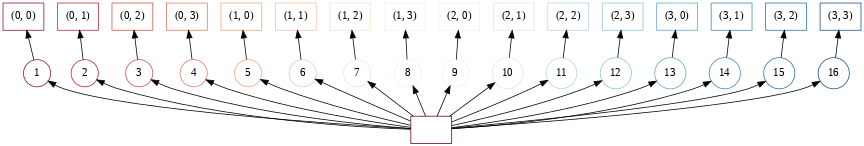

In [22]:
darr.visualize(color="order", size="9,10!")

In [ ]:
darr.chunks, darr.chunksize, darr.npartitions

(((250, 250, 250, 250), (250, 250, 250, 250)), (250, 250), 16)

In [23]:
res = darr.sum(axis=0)

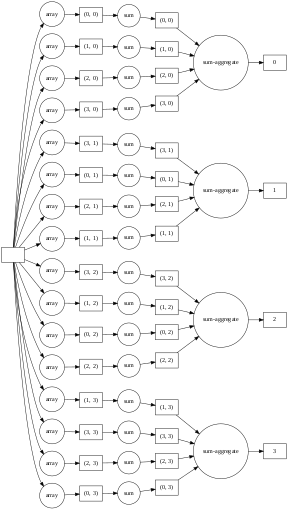

In [ ]:
res.visualize(rankdir="LR", size="3,20!") # Graph of methods we applied
# If we have a graph structure with many independent nodes per level in our implementation, Dask will be able to 
# parallelize it and we will get speedup, if our problem is sufficiently large.

In [ ]:
res.compute().shape

(1000,)

In [24]:
def numpy_mean(size=(10, 10)):
  arr = np.random.random(size=size)
  return arr.mean()

def dask_mean(size=(10, 10)):
  if size[0] > 10000: chunks = (1000, 1000)
  else: chunks = (int(size[0]/10), int(size[1]/10))
  
  arr = da.random.random(size=size, chunks=chunks)
  y = arr.mean()
  return y.compute()

In [25]:
import time

def dask_arr_chk():
  sizes = []
  times = []
  size = 10
  for i in range(5):
    dim1 = size ** (i+1)
    for j in range(4):
      dim2 = size ** (j+1)
      if dim1*dim2 in sizes: continue
      st = time.time()
      dask_mean(size=(dim1, dim2))
      en = time.time()
      sizes.append(dim1*dim2)
      times.append(en-st)
  return sizes, times

def numpy_arr_chk():
  sizes = []
  times = []
  size = 10
  for i in range(4):
    dim1 = size ** (i+1)
    for j in range(4):
      dim2 = size ** (j+1)
      if dim1*dim2 in sizes: continue
      st = time.time()
      numpy_mean(size=(dim1, dim2))
      en = time.time()
      sizes.append(dim1*dim2)
      times.append(en-st)
  return sizes, times

In [26]:
%%time
x1, y1 = numpy_arr_chk()
x2, y2 = dask_arr_chk()

CPU times: user 17.9 s, sys: 656 ms, total: 18.6 s
Wall time: 10.4 s


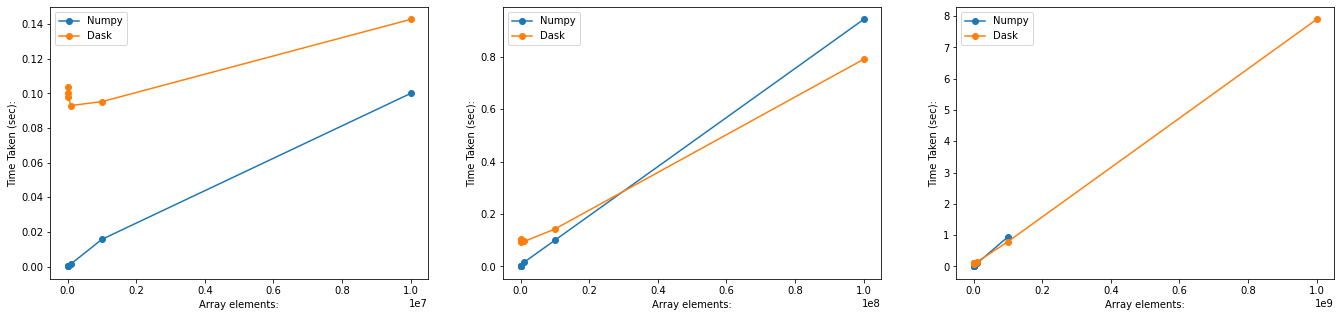

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(23, 5))
axs[0].plot(x1[:-1], y1[:-1], "o-", label="Numpy")
axs[0].plot(x2[:-2], y2[:-2], "o-", label="Dask")
axs[0].set_xlabel("Array elements:")
axs[0].set_ylabel("Time Taken (sec):")
axs[0].legend()

axs[1].plot(x1, y1, "o-", label="Numpy")
axs[1].plot(x2[:-1], y2[:-1], "o-", label="Dask")
axs[1].set_xlabel("Array elements:")
axs[1].set_ylabel("Time Taken (sec):")
axs[1].legend()

axs[2].plot(x1, y1, "o-", label="Numpy")
axs[2].plot(x2, y2, "o-", label="Dask")
axs[2].set_xlabel("Array elements:")
axs[2].set_ylabel("Time Taken (sec):")
axs[2].legend()

In low dimensions, numpy is taking less time than Dask because Dask has to create many processes for the number of workers we set during definition of *Client* declaration (Fig 1). But as number of array elements increases we see that Dask takes less time than Numpy (Fig 2). Beyond that numpy is not able to compute because it is not able to bring whole array into memory, but Dask is able to by computings many blocks in sequential order. (Fig 3).

### b) DataFrame:

In [31]:
import dask.dataframe as dd
import numpy as np
import gc
gc.enable()

In [33]:
arr = np.random.normal(0.0, 1.0, size=(1000000, 10))
df = dd.from_array(arr, chunksize=50000, columns=[f"col-{i+1}" for i in range(10)])
del arr
gc.collect()

247

In [34]:
df

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10
npartitions=20,,,,,,,,,,
0,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
50000,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
950000,...,...,...,...,...,...,...,...,...,...
999999,...,...,...,...,...,...,...,...,...,...


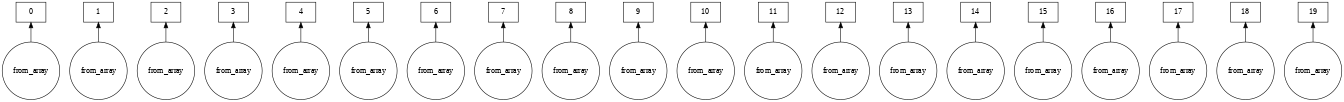

In [35]:
df.visualize(size="14,16!")

In [36]:
df.head() # Not lazy beacuse it doesn't take much computation

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10
0,1.054381,-0.863633,2.181520,-0.535736,-0.201017,-1.903619,0.104990,0.021806,1.184911,1.488186
1,1.344108,-0.675325,-1.010073,-1.492964,-1.380618,-0.106668,1.365358,-0.473774,-0.062923,1.237646
2,-1.198370,-0.188389,0.965038,-0.029921,0.623035,-0.152453,0.704731,0.260195,0.053612,-2.131230
3,-0.886348,-0.703291,-0.174527,0.216753,0.560816,2.613201,-0.223852,-0.698994,0.129027,0.688576
4,0.506749,1.880170,-0.269010,1.503210,-0.109030,-0.467409,0.493216,-0.810424,1.436614,0.204923


In [37]:
df.tail()

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10
49995,1.351675,1.165250,0.051993,0.005899,-0.452694,2.311017,0.121534,-1.052806,-0.747018,-0.490740
49996,-1.291633,-1.432446,0.656969,1.816545,1.211105,0.341901,-1.640277,-1.448814,-0.916282,-0.608910
49997,-0.172128,0.519959,0.062687,1.546719,-0.404329,-0.645154,-0.858367,-0.655015,0.904426,-1.123622
49998,-1.794037,-0.194600,0.115633,0.300115,-0.017753,0.652951,-0.505943,-0.245282,-0.508725,0.598502
49999,0.131706,-0.449839,0.487297,-0.173112,-1.751360,-0.801166,-0.915758,0.034578,-0.311487,-1.781134


In [38]:
df["col-1"] = (df["col-1"]*10).astype(int)

In [39]:
agg = df.groupby(by=["col-1"]).aggregate(["sum", "std", "max", "min", "mean"])

In [40]:
agg.head(2)

col-2                        ... col-10                              
           sum std      max      min  ...    std       max       min      mean
col-1                                 ...                                     
-48   -0.76037 NaN -0.76037 -0.76037  ...    NaN -0.107795 -0.107795 -0.107795
-46   -0.16012 NaN -0.16012 -0.16012  ...    NaN  1.181272  1.181272  1.181272

[2 rows x 45 columns]

In [41]:
columns = []
for col in agg.columns.levels[0]:
  for a in agg.columns.levels[1]:
    columns.append(f"{col}.{a}")

agg.columns = columns
agg.head(2)

,col-10.max,col-10.mean,col-10.min,col-10.std,col-10.sum,col-2.max,col-2.mean,col-2.min,col-2.std,col-2.sum,col-3.max,col-3.mean,col-3.min,col-3.std,col-3.sum,col-4.max,col-4.mean,col-4.min,col-4.std,col-4.sum,col-5.max,col-5.mean,col-5.min,col-5.std,col-5.sum,col-6.max,col-6.mean,col-6.min,col-6.std,col-6.sum,col-7.max,col-7.mean,col-7.min,col-7.std,col-7.sum,col-8.max,col-8.mean,col-8.min,col-8.std,col-8.sum,col-9.max,col-9.mean,col-9.min,col-9.std,col-9.sum
col-1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-48,-0.76037,NaN,-0.76037,-0.76037,-0.76037,0.199673,NaN,0.199673,0.199673,0.199673,-0.403105,NaN,-0.403105,-0.403105,-0.403105,1.032186,NaN,1.032186,1.032186,1.032186,1.224788,NaN,1.224788,1.224788,1.224788,-0.662367,NaN,-0.662367,-0.662367,-0.662367,-0.919697,NaN,-0.919697,-0.919697,-0.919697,-0.558851,NaN,-0.558851,-0.558851,-0.558851,-0.107795,NaN,-0.107795,-0.107795,-0.107795
-46,-0.16012,NaN,-0.16012,-0.16012,-0.16012,0.385800,NaN,0.385800,0.385800,0.385800,-2.110167,NaN,-2.110167,-2.110167,-2.110167,1.248518,NaN,1.248518,1.248518,1.248518,0.076768,NaN,0.076768,0.076768,0.076768,-1.353570,NaN,-1.353570,-1.353570,-1.353570,0.816053,NaN,0.816053,0.816053,0.816053,0.835235,NaN,0.835235,0.835235,0.835235,1.181272,NaN,1.181272,1.181272,1.181272


In [42]:
df_new = df.merge(agg.reset_index(), how="left", on="col-1")

In [43]:
df_new

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10,col-10.max,col-10.mean,col-10.min,col-10.std,col-10.sum,col-2.max,col-2.mean,col-2.min,col-2.std,col-2.sum,col-3.max,col-3.mean,col-3.min,col-3.std,col-3.sum,col-4.max,col-4.mean,col-4.min,col-4.std,col-4.sum,col-5.max,col-5.mean,col-5.min,col-5.std,col-5.sum,col-6.max,col-6.mean,col-6.min,col-6.std,col-6.sum,col-7.max,col-7.mean,col-7.min,col-7.std,col-7.sum,col-8.max,col-8.mean,col-8.min,col-8.std,col-8.sum,col-9.max,col-9.mean,col-9.min,col-9.std,col-9.sum
npartitions=20,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


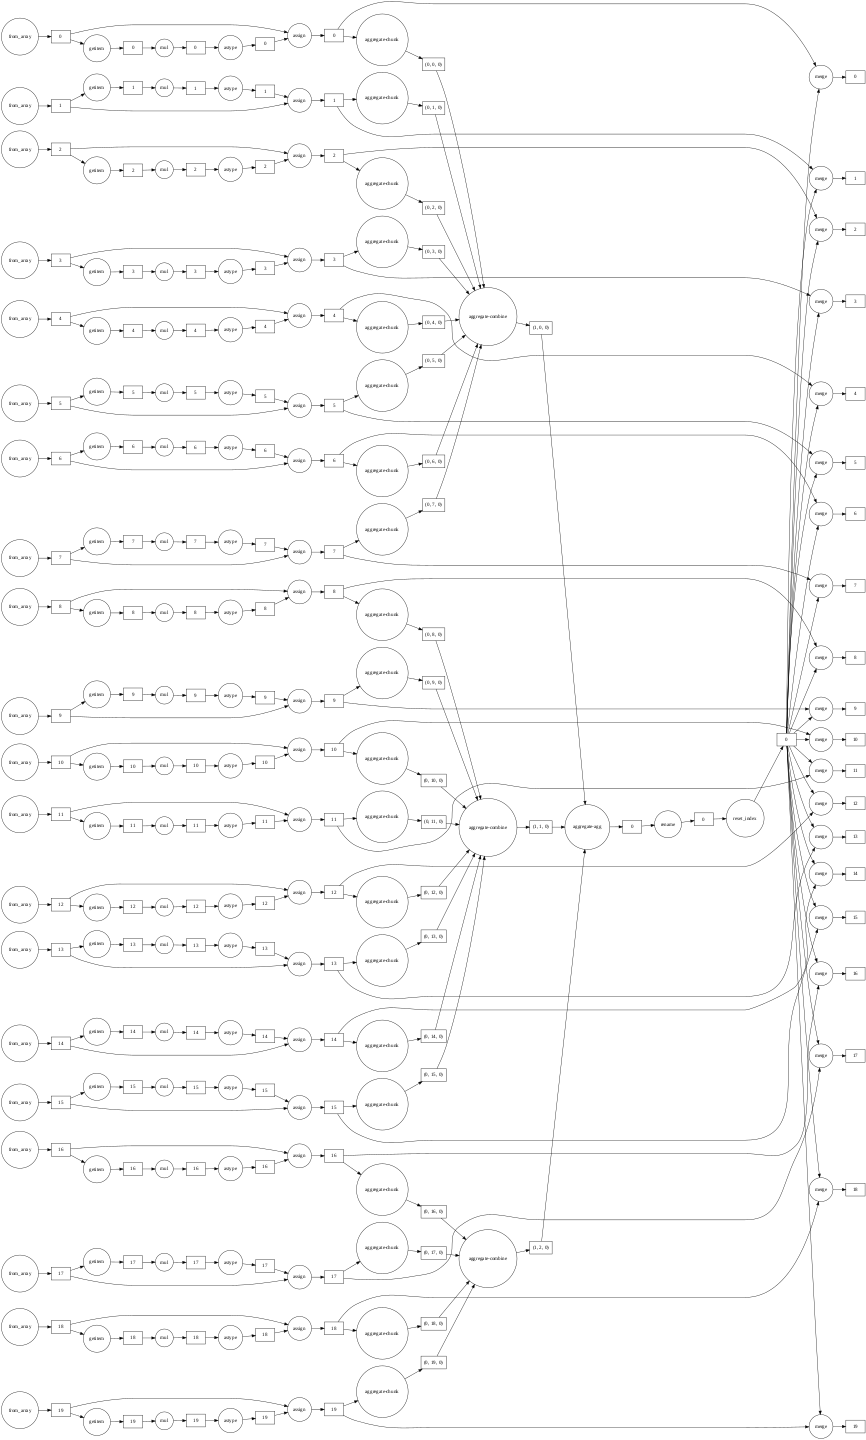

In [44]:
df_new.visualize(rankdir="LR", size="20, 15!")

In [ ]:
df_new.compute().head()

,col-1,col-2,col-3,col-4,col-5,col-6,col-7,col-8,col-9,col-10,...,col-8.max,col-8.mean,col-8.min,col-8.std,col-8.sum,col-9.max,col-9.mean,col-9.min,col-9.std,col-9.sum
0,-60,0.130116,1.245027,-1.136380,-0.470103,-0.941553,-1.671139,0.145971,2.293270,0.155823,...,-436.763233,0.998168,3.957593,-3.943839,-0.013558,-298.565293,0.993525,3.915293,-4.024406,-0.009268
1,-20,1.908346,-1.550921,-0.457190,-2.577153,-1.934383,-1.645623,-0.591864,1.537130,-2.281100,...,170.245958,1.006248,4.544046,-4.234739,0.004340,158.471773,0.996160,3.838703,-3.834235,0.004040
2,0,-0.088429,1.380285,0.308579,0.633180,0.193406,0.304017,-1.595323,-0.491884,-0.622066,...,-91.181243,1.004919,4.289157,-4.790374,-0.001144,-274.389036,1.000430,3.920591,-4.156023,-0.003441
3,120,1.088529,1.100429,1.195908,1.054931,0.169908,-0.811806,0.355700,1.353377,-0.301842,...,-128.199559,0.993309,3.978109,-3.946863,-0.007043,-15.423090,1.010217,4.344170,-3.792479,-0.000847
4,60,-0.243633,-0.429093,-0.274839,2.432883,-0.425719,1.071818,-1.019423,0.236055,1.932841,...,-116.715633,0.998924,4.284917,-4.321277,-0.003632,-197.993101,1.005309,4.386022,-4.163965,-0.006161


In [ ]:
df_new.shape[0].compute(), df_new.shape[1]

(1000000, 55)

### c) Bag:

In [45]:
import dask.bag as db

lst = []
for i in range(5):
  lst.append({f"Name.{name}": value for name, value in np.random.randint(1, 10, (5, 2))})
  lst.append(np.random.randint(2, 5, (2, 4)))
  lst.append(np.random.randint(1, 1000, (1,)))
  lst.append([i for i in range(100, 200, 10)])
  
b = db.from_sequence(lst)
b.take(1)

({'Name.4': 6, 'Name.5': 4, 'Name.8': 6, 'Name.9': 4},)

In [46]:
def fil(el):
  if type(el)!=dict and type(el)!=list: return True
  else: return False

filmap = b.filter(fil).map(lambda x: x**2)

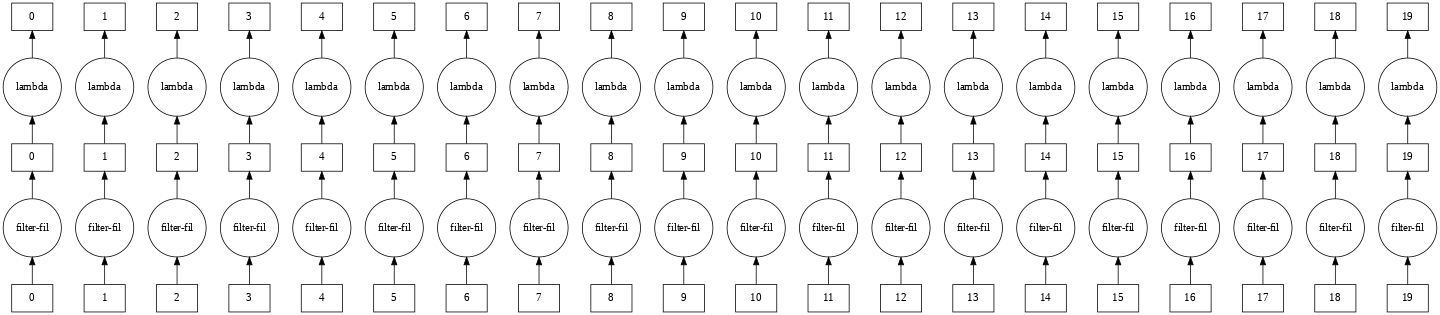

In [47]:
filmap.visualize(size="15,10!")

In [48]:
filmap.compute()

[array([[16,  9,  4,  4],
        [ 9,  4,  4,  4]]), array([7056]), array([[16, 16, 16, 16],
        [ 9, 16,  4,  9]]), array([143641]), array([[16,  4,  4, 16],
        [ 4, 16,  9,  4]]), array([327184]), array([[ 4, 16,  9, 16],
        [ 9, 16,  4,  9]]), array([277729]), array([[16,  9, 16, 16],
        [16,  4,  4, 16]]), array([336400])]

In [49]:
comp = filmap.flatten().mean()

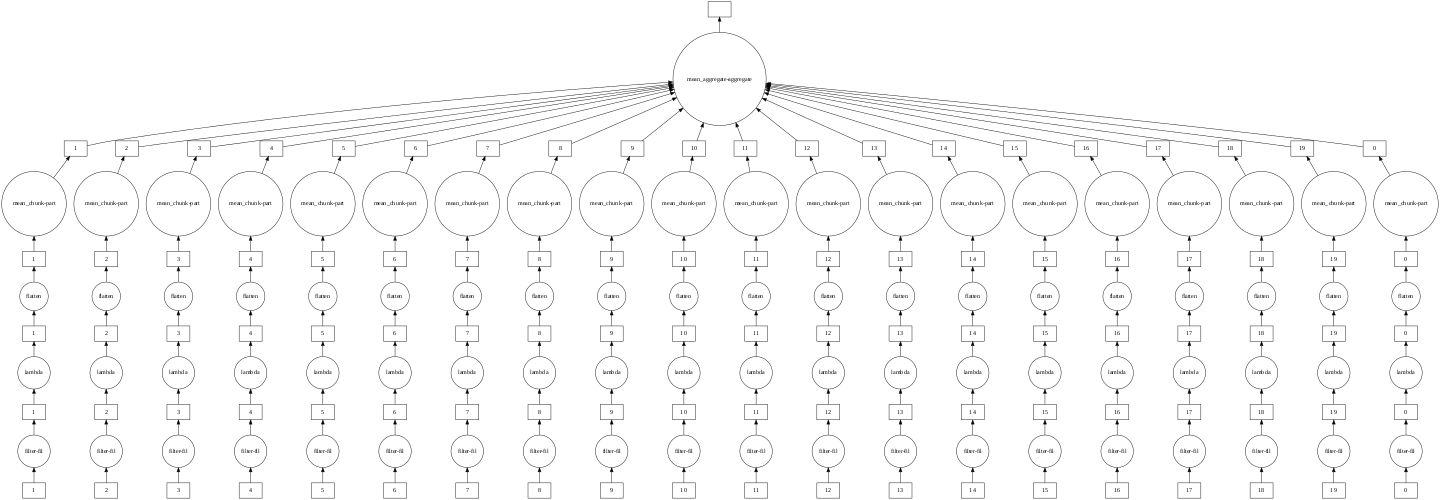

In [50]:
comp.visualize(size="15, 15!")

In [51]:
comp.compute()

array([72808.33333333, 72808.        , 72805.6       , 72808.        ])

# 3. Delayed

In [53]:
import dask.delayed as delay

@delay
def sq(x):
  return x**2

@delay
def add(x, y):
  return x+y

@delay
def sum(arr):
  sum = 0
  for i in range(len(arr)): sum+=arr[i]
  return sum

In [54]:
# Adding tasks here is like adding nodes to graphs.
# You can add new taks based on results of prevoius tasks.
# Dask won't compute them right away. It will make a graph as
# you call them. And then COmpute the whole graph parallely.
lst = list(np.arange(1, 11))

for i in range(3):
  temp = []
  if i == 0:
    for j in range(0, len(lst)):
      temp.append(sq(lst[j]))
  elif i == 1:
    for j in range(0, len(lst)-1, 2):
      temp.append(add(lst[j], lst[j+1]))
  else:
    temp.append(sum(lst))
  lst = temp # New functions will be computed on last results
  
lst

[Delayed('sum-929511ea-ce36-463f-96cb-125a54426cab')]

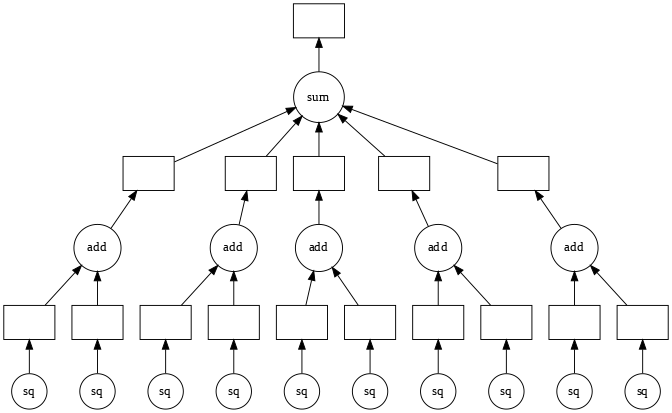

In [55]:
lst[0].visualize(size="7,10!")

In [56]:
lst[0].compute()

385

# In-class Exercise: ZTF single day file exploration with Async, Promises and Orchestrator

In [5]:
import time
import sys
import tarfile
import os
import functools

from pprint import pprint

from fastavro import reader, writer

In [8]:
ztf_file="data/ztf_public_20190302.tar.gz"
ztf_date="20190302"

In [9]:
# untar the file
untar_file = True

if untar_file:
    print("extracting alerts from %s" % ztf_file)
    tar = tarfile.open(ztf_file)
    tar.extractall(path="in/%s" % ztf_date)
    tar.close()
else:
    print("skipping file extraction")
    if not os.path.exists("in/%s" % ztf_date):
        raise(RuntimeError("ZTF alerts directory %s does not exists"))
    else:
        print("Using in/%s as ZTF alert directory" % ztf_date)

ztf_in="in/%s" % ztf_date


extracting alerts from data/ztf_public_20190302.tar.gz


In [10]:
# count the alerts in the directory

num_alerts=0

avro_files = []
avro_limit = 10000

for file in os.listdir(ztf_in):
    if file.endswith(".avro"):
        num_alerts+=1
        if num_alerts < avro_limit:
            avro_files.append(file)

print("num alerts: %d" % num_alerts)

num alerts: 174


In [13]:
file = "790250264315015001.avro"

with open("%s/%s" % (ztf_in,file), 'rb') as fo:
    avro_reader = reader(fo)
    for record in avro_reader:
        pprint(record)


{'candid': 790250264315015001,
 'candidate': {'aimage': 0.3970000147819519,
               'aimagerat': 0.2450617253780365,
               'bimage': 0.30000001192092896,
               'bimagerat': 0.18518517911434174,
               'candid': 790250264315015001,
               'chinr': 1.4609999656677246,
               'chipsf': 46.34967041015625,
               'classtar': 1.0,
               'clrcoeff': 0.14304399490356445,
               'clrcounc': 0.007853991352021694,
               'clrmed': 0.5249999761581421,
               'clrrms': 0.13937300443649292,
               'dec': 5.4764628,
               'decnr': 5.4769151,
               'diffmaglim': 15.199528694152832,
               'distnr': 9.453246116638184,
               'distpsnr1': 9.581225395202637,
               'distpsnr2': 11.964457511901855,
               'distpsnr3': 14.75849437713623,
               'dsdiff': -9.369754791259766,
               'dsnrms': 41.81718444824219,
               'elong': 1.3233333826

                                 b'\xf0\xdf\xa9\xa9\xdbf^[t#\xe7\xc3C\x0f!O'
                                 b'\xd7\xc3s~\xc6\x17\x94\xa0\x9e/\xc8p'
                                 b'\r\xd0\xefZ\xe4\xd2:\xe8Lb\xee\x1d'
                                 b'\x91\x9c\x9f\xf1\x14\x9e\x88,\xb7!\xb5\xdc'
                                 b'\xcc`\xf05\x9c\x17B\x1e}\x897\xbe'
                                 b'\x8f\xb6E\xc4\xff\xa4\xa6\x8f'
                                 b'\x01\xe0\xce\x9f\xfc\x11\r\x8eMO\xdf\x8a'
                                 b'\xc2K\x19\xf0|I\xc8\x12\x95\xf0\xe7U'
                                 b'R\xa3\x87Ad\xac\xc7\n8\x16\x9b|\x8f~=\xa6'
                                 b'\xce]y\xee,\\\xb3\x98\xba\xb7$\x0b'
                                 b'\xcf\x98\x86\xe7![\x87\xc1\xb9\xed\xe1\x90'
                                 b't\xdco\xc3b\x99Cx\xc8\xb2hB/\xf4-0\x1f~\x929'
                                 b'\x9e5\x0f\x8d@\x1b\x0e1\x07E[\xca'
                                 b'

In [14]:
# get the date distribution

dates={}

log_each    = 1000
num_records = 0

for file in avro_files:
    with open("%s/%s" % (ztf_in,file), 'rb') as fo:
        avro_reader = reader(fo)
        for record in avro_reader:
            #pprint(record)
            num_records+=1
            jd = record["candidate"]["jd"]
            ts_key = str(jd)
            if ts_key in dates:
                dates[ts_key]+=1
            else:
                dates[ts_key]=1

        if (num_records % log_each) == 0:
            print("%.2f %% completed" % ((num_records/avro_limit) * 100))

print(dates)

{'2458544.6713194': 112, '2458544.7498032': 37, '2458544.7502662': 25}


# And now with multiprocessing?

In [14]:
#from multiprocessing import Pool
from pathos.multiprocessing import Pool
import numpy as np
from tqdm.auto import tqdm

# using only asyncronous call and list comprehensions

def map_ts_key(file):
    num_records = 0
    dates={}
    with open("%s/%s" % (ztf_in,file), 'rb') as fo:
        avro_reader = reader(fo)
        for record in avro_reader:
            #pprint(record)
            num_records+=1
            jd = record["candidate"]["jd"]
            ts_key = str(jd)
            if ts_key in dates:
                dates[ts_key]+=1
            else:
                dates[ts_key]=1 
            
    return dates

dates = []
with Pool(4) as p:
    for date in tqdm(p.map(map_ts_key, avro_files), total=len(avro_files)):
        dates.append(date)
        
print(dates)

  0%|          | 0/174 [00:00<?, ?it/s]

[{'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.7502662': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.7502662': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7502662': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.7498032': 1}, {'2458544.7498032': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7502662': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7502662': 1}, {'2458544.7498032': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.6713194': 1}, {'2458544.7498032': 1}, {'2458544.7498032': 1}, {'2458544.74980

In [19]:
import copy

for ii, date in enumerate(dates):
    if ii == 0:
        merged = copy.copy(date)
    else:
        for k in date.keys():
            if k not in merged:
                merged[k] = date[k]
            else:
                merged[k] = merged[k] + date[k]
print(merged)

{'2458544.6713194': 112, '2458544.7498032': 37, '2458544.7502662': 25}
